In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize,poly)

import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm


c:\Users\clemd\anaconda3\envs\datamining\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Question 1 #
Pour cette question, comme au devoir 2, vous devez d’abord obtenir vos
données personnalisées (mondata1) en fonction de votre matricule (voir les instructions à cet effet sur
le site). Il s’agit d’un échantillon aléatoire de 500 observations de la base de données Wage du package
ISLR2.

In [57]:
from sklearn.model_selection import train_test_split
#Génération de données basé sur ma matricule
#utilisation du wage dataset
wage = load_data("Wage")
#print(wage.columns)
#Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass','health', 'health_ins', 'logwage', 'wage'],dtype='object')
wage['health'] = wage['health'].apply(lambda x: 1 if x == "2. >=Very Good" else 0)
matricule = 2405979
np.random.seed(matricule)
train_data, valid_data = train_test_split(wage, test_size=500, random_state=matricule)
X_train = train_data[['age', 'wage']]
y_train = train_data['health']


Vous disposez ainsi de 500 observations sous la forme {(xi
, yi), i = 1, . . . , 500}, où yi représente l’état
de santé du travailleur (health) codée 1 (très bon ), 0 (bon ou moins) ; xi = (xi1, xi2)
⊤, où xi1 est l’âge
(age) du travailleur et xi2 son salaire (wage).
Pour les données décrites ci-dessus, après avoir déterminé le degré de flexibilité approprié de chaque
méthode, on veut sélectionner la meilleure méthode de classification parmi les suivantes : le KNN, la
régression logistique, l’analyse discriminante linéaire et l’analyse discriminante quadratique.

a) KNN.
1. En utilisant les techniques de validation croisée «LOOCV» et «5-Fold CV» sur les 500 observations, estimer le taux d’erreur test pour différentes valeurs du nombre de voisins, K, avec
K = 1, 2, . . . , 180. Tracer la courbe du taux d’erreur en fonction de 1/K.
2. Compte tenu des résultats ci-dessus, quelle valeur du nombre de voisins K devrait-on utiliser
pour la classification des données du contexte par le KNN ? Justifier brièvement.

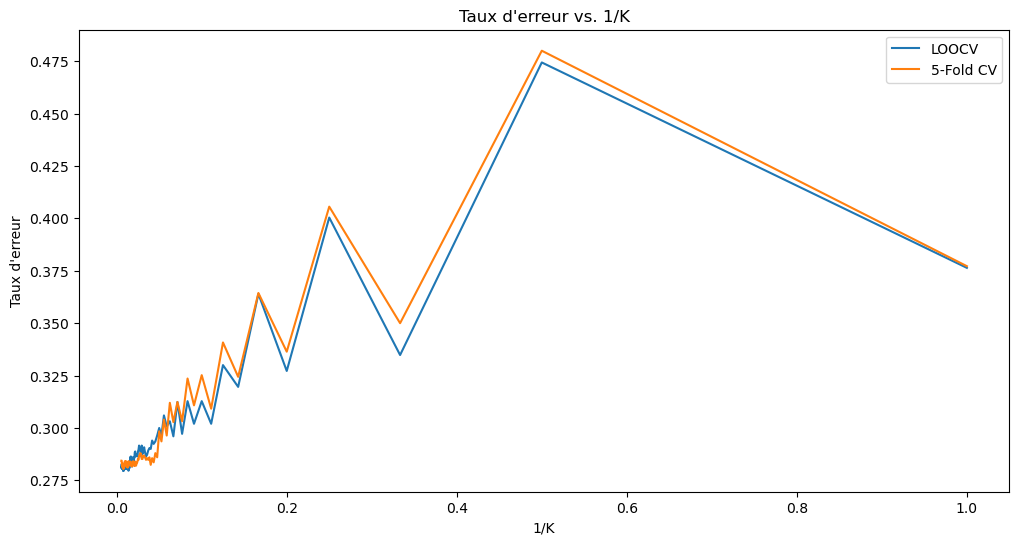

K optimal pour LOOCV: 72
K optimal pour 5-Fold CV: 128


In [54]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#loocv: on divise les données de manière à ce que chaque observation soit utilisée comme un cas de test unique (les autres obs servent donc à entrâiner)
#-> on entraîne n-1 obs, on test avec 1 obs et ce processus est répeté n fois
# + : elle utilise toutes les données -> bonne estimation de l'erreur
# - : coûteuse si n est grand
# 5Fold: on divise les données en 5 sous-ensembles
# -> on entraine le modèle sur 4 sous-ensembles, on test sur un -> répète le processus 5 fois
# + : elle utilise moins de données que loocv -> moins coûteuse
# - : -> moins précis aussi
erreur_loocv = []
erreur_5fold = []
for k in range(1,181):
    knn = KNeighborsClassifier(n_neighbors=k)
    # loocv
    #https://www.statology.org/leave-one-out-cross-validation-in-python/
    #Provides train/test indices to split data in train/test sets. Each sample is used once as a test set (singleton) while the remaining samples form the training set.
    # Note: LeaveOneOut() is equivalent to KFold(n_splits=n) and LeavePOut(p=1) where n is the number of samples.
    loo = LeaveOneOut()
    loo_scores = cross_validate(knn, X_train, y_train, cv=loo,scoring='accuracy') 
    erreur_loocv.append(1-np.mean(loo_scores['test_score']))
    # 5fold Cv
    kf = KFold(n_splits=5, shuffle=True, random_state=matricule)
    kfold_scores = cross_validate(knn, X_train, y_train, cv=kf,scoring='accuracy')
    # kfold_error = 1 - kfold_scores.mean()
    erreur_5fold.append(1- np.mean(kfold_scores['test_score']))

plt.figure(figsize=(12, 6))
plt.plot([1/k for k in range(1, 181)], erreur_loocv, label='LOOCV')
plt.plot([1/k for k in range(1, 181)], erreur_5fold, label='5-Fold CV')
plt.xlabel('1/K')
plt.ylabel('Taux d\'erreur')
plt.title('Taux d\'erreur vs. 1/K')
plt.legend()
plt.show()
optimal_k_loocv = erreur_loocv.index(min(erreur_loocv)) + 1
optimal_k_kfold = erreur_5fold.index(min(erreur_5fold)) + 1

print(f"K optimal pour LOOCV: {optimal_k_loocv}")
print(f"K optimal pour 5-Fold CV: {optimal_k_kfold}")

b) Régression logistique
Dans les équations suivantes p(x) représente p(x; β) = P (Y = 1 | X = x), la probabilité que le
travailleur soit en très bonne santé étant donné les mesures x = (x1, x2)
⊤ observées.
On envisage deux modèles de régression logistique dont les équations sont :

1. En utilisant les techniques de validation croisée «LOOCV» et «5-Fold CV» sur les 500 observations, estimer le taux d’erreur test pour chacun des 2 modèles.
2. Compte tenu des résultats ci-dessus, lequel des 2 modèles de régression logistique devrait-on
utiliser pour la classification des données du contexte ? Justifier brièvement.

In [39]:
# from sklearn.linear_model import LogisticRegression
# #section 4.7.2
# # Définir les caractéristiques pour les deux modèles
# X_model1 = Auto_train[['age', 'wage']]
# X_model2 = Auto_train[['age', 'wage']].copy()
# X_model2['age^2'] = X_model2['age']**2
# X_model2['wage^2'] = X_model2['wage']**2
# y = Auto_train['health']

# model1 = LogisticRegression()
# loo = LeaveOneOut()
# mod_1_loo = cross_validate(model1, X_model1, y, cv=loo, scoring='accuracy')
# error_loo_mod1 = 1 - np.mean(mod_1_loo['test_score'])


# kfold = KFold(n_splits=5, shuffle=True, random_state=matricule)
# mod_1_kfold = cross_validate(model1, X_model1, y, cv=kfold, scoring='accuracy')
# kfold_error_model1 = 1 - np.mean(mod_1_kfold['test_score'])

# model2 = LogisticRegression()

# loocv_results_model2 = cross_validate(model2, X_model2, y, cv=loo, scoring='accuracy')
# loocv_error_model2 = 1 - np.mean(loocv_results_model2['test_score'])


# kfold_results_model2 = cross_validate(model2, X_model2, y, cv=kfold, scoring='accuracy')
# kfold_error_model2 = 1 - np.mean(kfold_results_model2['test_score'])

# print(f"Taux d'erreur LOOCV pour Modèle 1: {error_loo_mod1}")
# print(f"Taux d'erreur 5-Fold CV pour Modèle 1: {kfold_error_model1}")
# print(f"Taux d'erreur LOOCV pour Modèle 2: {loocv_error_model2}")
# print(f"Taux d'erreur 5-Fold CV pour Modèle 2: {kfold_error_model2}")
# # Model 1 LOOCV Error: 0.2820
# # Model 1 5-Fold CV Error: 0.2810
# # Model 2 LOOCV Error: 0.2823
# # Model 2 5-Fold CV Error: 0.2797

Taux d'erreur LOOCV pour Modèle 1: 0.28
Taux d'erreur 5-Fold CV pour Modèle 1: 0.27879999999999994
Taux d'erreur LOOCV pour Modèle 2: 0.2804
Taux d'erreur 5-Fold CV pour Modèle 2: 0.27960000000000007


In [65]:

import statsmodels.api as sm
from sklearn.model_selection import KFold, LeaveOneOut

#section 4.7.2 from ISLP website
#modèle 1 : b0 + b1*x1+b2*x2
#modèle 2 : b0 + b1*x1+b2*x2 +b3*x1^2 ¨+b4*x2^2
X_train_1 = sm.add_constant(X_train)
X_train_2 = X_train.copy()
#on inclut les termes quadratiques
X_train_2['age^2']= X_train['age']**2
X_train_2['wage^2']= X_train['wage']**2
X_train_2 = sm.add_constant(X_train_2)
loo = LeaveOneOut()
kf = KFold(n_splits=5, shuffle=True, random_state=matricule)

def mean_error(X, y, cv):
    errors = []
    #pour chacun des fold on va calucler l'erreur puis prendre la moyenne
    for i, j in cv.split(X):
        X_train, X_test= X.iloc[i],X.iloc[j]
        y_train, y_test= y.iloc[i],y.iloc[j]
        #from ISLP: The syntax of sm.GLM() is similar to that of sm.OLS(), except that
        # we must pass in the argument family=sm.families.Binomial() in order to
        # tell statsmodels to run a logistic regression rather than some other type of
        # generalized linear model.
        #on fit un logistique régression comme dans le livre
        glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
        result = glm.fit()
        probs= result.predict(X_test)>0.5 #est-ce que ça va être utile de changer ce 0.5 ? 
        #voir si c'est classifié de la même manière
        error = np.mean(probs!=y_test)
        errors.append(error)
    return np.mean(errors)
#enft j'aurais juste pu utiliser à nv cross_validate mais pas sûre si il va bien faire la logistique régression 
#si je précise pas sm.families.Binomial()
model1_loo = mean_error(X_train_1, y_train, loo)
model1_kf = mean_error(X_train_1, y_train, kf)
model2_loo = mean_error(X_train_2, y_train, loo)
model2_kf = mean_error(X_train_2, y_train, kf)
print("M1 LOOCV", model1_loo)
print("M1 5-Fold", model1_kf)
print("M2 LOOCV", model2_loo)
print("M2 5-Fold", model2_kf)


M1 LOOCV 0.2848
M1 5-Fold 0.28480000000000005
M2 LOOCV 0.2848
M2 5-Fold 0.28480000000000005


c) Analyse discriminante.
1. En utilisant les techniques de validation croisée «LOOCV» et «5-Fold CV» sur les 500 observations, estimer le taux d’erreur test de l’analyse discriminante linéaire (LDA) et celui de l’analyse
discriminante quadratique (QDA).
2. Compte tenu des résultats ci-dessus, laquelle des deux analyses discriminantes devrait-on
utiliser pour la classification des données du contexte ? Justifier brièvement.


In [46]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import LeaveOneOut, KFold
#section 4.7.3 et 4.7.4
# Linear Discriminant Analysis (LDA)
# SincetheLDAestimatorautomaticallyaddsanintercept,weshouldre
# movethecolumncorrespondingtotheinterceptinbothX_trainandX_test.

loo = LeaveOneOut()
kf = KFold(n_splits=5, shuffle=True, random_state=matricule)
lda_model = LDA(store_covariance=True)
qda_model = QDA(store_covariance=True)
#on va faire pareil que l'exo précedent mais sans binomial
#(à nv je pense qu'on aurait pu utiliser cross_validate mais bon)
def mean_error(model, X, y, cv):
    errors = []
    #pour chaque fold
    for i, j in cv.split(X):
        model.fit(X.iloc[i], y.iloc[i])
        predictions = model.predict(X.iloc[j])
        error = np.mean(predictions!=y.iloc[j])
        errors.append(error)
    return np.mean(errors)

lda_loocv_error = mean_error(lda_model, X_train, y_train, loo)
lda_kfold_error = mean_error(lda_model, X_train, y_train, kf)

qda_loocv_error = mean_error(qda_model, X_train, y_train, loo)
qda_kfold_error = mean_error(qda_model, X_train, y_train, kf)

print("LDA LOOCV ", lda_loocv_error)
print("LDA 5-Fold ", lda_kfold_error)
print("QDA LOOCV ", qda_loocv_error)
print("QDA 5-Fold ", qda_kfold_error)



LDA LOOCV  0.2792
LDA 5-Fold  0.2772
QDA LOOCV  0.286
QDA 5-Fold  0.28640000000000004


d) Résumé graphique et comparaison des méthodes.
Tracer le nuage des 500 points (2 couleurs de votre choix) et ajouter au graphique les courbes
(trois en tout, similaires à celles de la figure 5.7 page 207 dans ISLr) séparant les deux classes
dans chacun des cas suivants :
- le KNN (avec la valeur optimale retenue du nombre de voisins K).
- le modèle de régression logistique retenu (parmi les deux modèles considérés) ;
- l’analyse discriminante retenue (LDA ou QDA).
Comparer les trois méthodes en utilisant leurs matrices de confusion des indices de performance

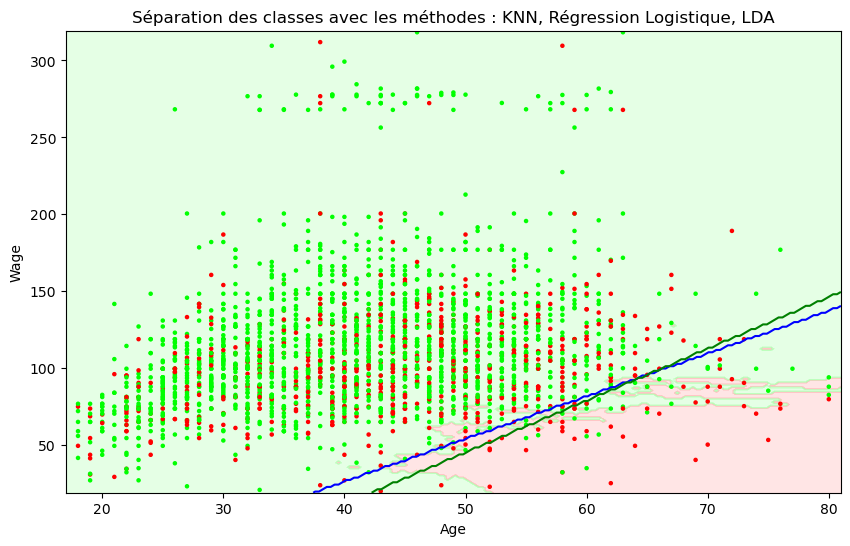

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from ISLP import load_data
from ISLP import confusion_table

# comme au devoir 2
##source: https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/neighbors/plot_classification.html
# matricule = 2405979
#je vais redefinir X et y avec .values sinon j'ai des erreurs après pcq je prends pas les values
X = train_data[['age', 'wage']].values
y = train_data['health'].values

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#arrange prend trop de mémoire donc je remplace en utilisant linspace
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

#on fait comme au devoir 2 mais avec nos méthodes choisies
#knn, ici j'utilise le 72 que j'ai choisi à la question 1 a)
k = 72
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)
Z_knn = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z_knn = Z_knn.reshape(xx.shape)
log_model = LogisticRegression()
log_model.fit(X, y)
Z_log = log_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_log = Z_log.reshape(xx.shape)
lda = LinearDiscriminantAnalysis()  
lda.fit(X, y)
Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lda = Z_lda.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_knn, cmap=cmap_light, alpha=0.3)
plt.contour(xx, yy, Z_log, levels=[0.5], colors='blue')
plt.contour(xx, yy, Z_lda, levels=[0.5], colors='green')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s= 5)
plt.title("Séparation des classes avec les méthodes : KNN, Régression Logistique, LDA")
plt.xlabel('Age')
plt.ylabel('Wage')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()




In [106]:

knn_prediction = knn.predict(X)
print("Matrice de confusion pour KNN :")
c1 = confusion_table(y, knn_prediction)
print(c1)
print(classification_report(y, knn_prediction))




Matrice de confusion pour KNN :
Truth       0     1
Predicted          
0          42   670
1          16  1772
              precision    recall  f1-score   support

           0       0.72      0.06      0.11       712
           1       0.73      0.99      0.84      1788

    accuracy                           0.73      2500
   macro avg       0.72      0.53      0.47      2500
weighted avg       0.73      0.73      0.63      2500



In [108]:
pred_log = log_model.predict(X)
print("Matrice de confusion pour régression logistique:")
c2 = confusion_table(y, pred_log)
print(c2)
print(classification_report(y, pred_log))

Matrice de confusion pour régression logistique:
Truth       0     1
Predicted          
0          51   661
1          35  1753
              precision    recall  f1-score   support

           0       0.59      0.07      0.13       712
           1       0.73      0.98      0.83      1788

    accuracy                           0.72      2500
   macro avg       0.66      0.53      0.48      2500
weighted avg       0.69      0.72      0.63      2500



In [109]:
pred_lda = lda.predict(X)
print("Matrice de confusion pour LDA :")
c3 = confusion_table(y, pred_lda)
print(c3)
print(classification_report(y, pred_lda))

Matrice de confusion pour LDA :
Truth       0     1
Predicted          
0          45   667
1          30  1758
              precision    recall  f1-score   support

           0       0.60      0.06      0.11       712
           1       0.72      0.98      0.83      1788

    accuracy                           0.72      2500
   macro avg       0.66      0.52      0.47      2500
weighted avg       0.69      0.72      0.63      2500



# Question 2 #
Pour cette question on utilise les données iris (disponibles dans R).
Ces données sont de la forme {xi
, i = 1, . . . , n} où n = 150 et chaque xi est de dimension p = 4. On
considère que chaque xi = (xi1, xi2, xi3, xi4)
⊤, i = 1, . . . , n est une observation d’un vecteur aléatoire
X = (X1, X2, X3, X4)
⊤, où les variables X1 et X2 représentent la longueur et la largeur des sépales, X3 et
X4 la longueur et la largeur des pétales de fleurs. La distribution des probabilité exacte du vecteur X est
inconnue. On s’intéresse ici à l’estimation du paramètre θ défini par


a) (1 point) Donner l’expression d’un estimateur θˆ de θ en fonction des n observations

In [67]:
import numpy as np
from sklearn.datasets import load_iris

# utiliser iris dataset qui est dans sklearn
iris = load_iris()
X = iris.data  

# on veut calculer theta_prime qui est donné comme
#l'espérance du minimum entre : X2 + log(X1), X1 + X3 − 2X4, exp {−|X1 − X4|} , X2 + 3X3
#on en fait une fonction au cas ou si on veut le réutiliser plus tard
def theta_estimation(data):
    return np.mean(np.min([
        data[:, 1] + np.log(data[:, 0]),       
        data[:, 0] + data[:, 2] - 2 * data[:, 3], 
        np.exp(-np.abs(data[:, 0] - data[:, 3])), 
        data[:, 1] + 3 * data[:, 2]              
    ], axis=0))
theta_hat=theta_estimation(X)  
print(theta_hat)


0.010805041750993593


In [92]:

# from section 5_3_3 from ISLP website
def boot_SE(func, data, B=3500, seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = data.shape[0]
    for _ in range(B):
        idx = rng.choice(n, n, replace=True)
        value = func(data[idx])
        first_ += value
        second_ += value**2
    standard_error = np.sqrt(second_ / B - (first_ / B)**2)
    return standard_error




a) (2 points) En utilisant la technique de ré-échantillonnage «Bootstrap» (fonction boot()) avec
3500 répétitions, donner une estimation ponctuelle θˆ. Donner ensuite une estimation du biais et
une estimation de l’écart type (erreur-type) de θˆ

In [93]:
theta_original = theta_estimation(X)

# on veut utiliser le bootstrap avec n repetitions
repetitions=3500
bootstrap_estimates=np.zeros(repetitions)
np.random.seed(2405979)  
for i in range(repetitions):
    bootstrap_sample = X[np.random.choice(range(len(X)), size=len(X), replace=True)]
    bootstrap_estimates[i] = theta_estimation(bootstrap_sample)
bias = np.mean(bootstrap_estimates)-theta_original
std_error = boot_SE(theta_estimation, X, B=3500, seed=matricule)


print("Estimation bootstrap de θ:", np.mean(bootstrap_estimates))
print("Biais estimé:", bias)
print("Erreur-type estimée:", std_error)

Estimation bootstrap de θ: 0.010803673955830217
Biais estimé: -1.3677951633764979e-06
Erreur-type estimée: 0.00046011686643427345


b) (2 points) Déduire des résultats qui précèdent un intervalle de confiance pour θ au niveau de
confiance 95%. Commenter brièvement.


In [135]:
from statsmodels.stats.api import DescrStatsW
#found this on internet:
#https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.DescrStatsW.html
# tconfint_mean([alpha, alternative]) : two-sided confidence interval for weighted mean of data

output = DescrStatsW(bootstrap_estimates)
int_bas, int_haut = output.tconfint_mean(alpha=0.05, alternative='two-sided') 

print("Intervalle de confiance: ", [int_bas, int_haut])

# # Calculate the 95% confidence interval using the bootstrap estimates
# ci_lower = np.percentile(bootstrap_estimates, 2.5)
# ci_upper = np.percentile(bootstrap_estimates, 97.5)

# print("95% Confidence interval for theta:", (ci_lower, ci_upper))


Intervalle de confiance:  [0.010788874690969171, 0.010818473220691266]


# Question 3 #
Exercice no 8 page 285 ISLr (An Introduction to Statistical Learning).
Générer les données (mondata3) en fonction de votre matricule, voir les instructions à sur le site :

1. générer les observations xi selon une normale N(µ, σ2) avec µ et σ de votre choix ;

In [116]:
#------Code en R-------#
set.seed(0)
mu <- 0  
sigma <- 1  
sigma_epsilon <- 1  
x <- rnorm(n = 100, mean = mu, sd = sigma)
e <- rnorm(n = 100, mean = 0, sd = sigma_epsilon)
beta_0 <- 1
beta_1 <- 2
beta_2 <- -2
beta_3 <- -0.5
y <- beta_0 + beta_1 * x + beta_2 * x^2 + beta_3 * x^3 + e

#voir section  6.5 Lab: Linear Models and Regularization Methods dans ISLr
X_matrix <- poly(x, 10, raw = TRUE)
data <- data.frame(y = y, X_matrix)
#https://www.statology.org/regsubsets-in-r/
#https://rpubs.com/lmorgan95/ISLR_CH6_Solutions
best_subset <- regsubsets(y ~ ., data = data, nvmax = 10, method = "exhaustive")
summary_best <- summary(best_subset)
#Trouver les valeurs minimales et plot comme demandé dans ISLr
#pour les valeurs de cp,bic etc on peut les extraire de summary_best
cp_minimal <- which.min(summary_best$cp)
#----cp-----#
#https://ggplot2.tidyverse.org/reference/ggplot.html
# Note you will need to use the data.frame() function to create a single data set containing both X and Y .
cp_minimal <- which.min(summary_best$cp)
data.frame(cp = summary_best$cp, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = cp)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = cp_minimal, y = summary_best$cp[cp_minimal]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "Cp")

# ---- BIC ----
bic_minimal <- which.min(summary_best$bic)
data.frame(bic = summary_best$bic, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = bic)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = bic_minimal, y = summary_best$bic[bic_minimal]), color = "red", size = 10, shape = 4) +
  labs( x = "Number of Predictors", y = "BIC")

# ---- Adjusted R^2 ----
r_carre_ajuste_maximal <- which.max(summary_best$adjr2)
data.frame(adj_r2 = summary_best$adjr2, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = adj_r2)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = r_carre_ajuste_maximal, y = summary_best$adjr2[r_carre_ajuste_maximal]), color = "red", size = 10, shape = 4) +
  labs( x = "Number of Predictors", y = "Adjusted R-squared")
cat ("Optimal: \n")
cat("Cp:", cp_minimal, "BIC:", bic_minimal, "Adjusted R^2:", r_carre_ajuste_maximal, "\n")
#ici on va procéeder de la même manière mais en prenant la méthode forward et backward
#forward stepwise selection
model_fwd <- regsubsets(y ~ ., data = data, nvmax = 10, method = "forward")
summary_fwd <- summary(model_fwd)

cp_minimal_fwd <- which.min(summary_fwd$cp)
data.frame(cp = summary_fwd$cp, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = cp)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = cp_minimal_fwd, y = summary_fwd$cp[cp_minimal_fwd]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "Cp")
bic_minimal_fwd <- which.min(summary_fwd$bic)
data.frame(bic = summary_fwd$bic, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = bic)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = bic_minimal_fwd, y = summary_fwd$bic[bic_minimal_fwd]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "BIC")
r_carre_ajuste_maximal_fwd <- which.max(summary_fwd$adjr2)
data.frame(adj_r2 = summary_fwd$adjr2, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = adj_r2)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = r_carre_ajuste_maximal_fwd, y = summary_fwd$adjr2[r_carre_ajuste_maximal_fwd]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "Adjusted R-squared")

cat ("forward: \n")
cat("Cp:", cp_minimal_fwd, "BIC:", bic_minimal_fwd, "Adjusted R^2:", r_carre_ajuste_maximal_fwd, "\n")

#backward stepwise selection
model_bwd <- regsubsets(y ~ ., data = data, nvmax = 10, method = "backward")
summary_bwd <- summary(model_bwd)
cp_minimal_bwd <- which.min(summary_bwd$cp)
bic_minimal_bwd <- which.min(summary_bwd$bic)
r_carre_ajuste_maximal_bwd <- which.max(summary_bwd$adjr2)
data.frame(cp = summary_bwd$cp, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = cp)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = cp_minimal_bwd, y = summary_bwd$cp[cp_minimal_bwd]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "Cp")

data.frame(bic = summary_bwd$bic, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = bic)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = bic_minimal_bwd, y = summary_bwd$bic[bic_minimal_bwd]), color = "red", size = 4, shape = 4) +
  labs(x = "Number of Predictors", y = "BIC")
data.frame(adj_r2 = summary_bwd$adjr2, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = adj_r2)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = r_carre_ajuste_maximal_bwd, y = summary_bwd$adjr2[r_carre_ajuste_maximal_bwd]), color = "red", size = 10, shape = 4) +
  labs(x = "Number of Predictors", y = "Adjusted R-squared")
cat ("backward: \n")
cat("Cp:", cp_minimal_bwd, "BIC:", bic_minimal_bwd, "Adjusted R^2:", r_carre_ajuste_maximal_bwd, "\n")

print(coef(best_subset, id = cp_minimal))
print(coef(best_subset, id = bic_minimal))
print(coef(best_subset, id = r_carre_ajuste_maximal))
print(coef(model_fwd, id = cp_minimal_fwd))
print(coef(model_fwd, id = bic_minimal_fwd))
print(coef(model_fwd, id = r_carre_ajuste_maximal_fwd))
print(coef(model_bwd, id = cp_minimal_bwd))
print(coef(model_bwd, id = bic_minimal_bwd))
print(coef(model_bwd, id = r_carre_ajuste_maximal_bwd))


In [ ]:
#voir apd de page 282 sur ISLR
#We first set a random seed so that the results obtained will be reproducible. -> juste moi matricule
set.seed(2405979)
#ridge.mod <-glmnet(x, y, alpha = 0, lambda = grid)
#lasso.mod <-glmnet(x[train, ], y[train], alpha = 1,lambda = grid)

#fit a lasso model to the simulated data, Use cross-validation to select the optimal value of λ
#Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.
#as for question 1 I will use 5-Kfold
model_lasso <- cv.glmnet(y = y, x = X_matrix, alpha = 1, lambda = 10^seq(1, -2, length = 100),  standardize = TRUE, nfolds = 5)
plot_data <- data.frame(lambda = model_lasso$lambda, cv_mse = model_lasso$cvm, nonzero_coeff = model_lasso$nzero)
#https://www.statology.org/lasso-regression-in-r/
#on va refaire comme les autres questions avec mse et lambda
ggplot(plot_data, aes(x = lambda, y = cv_mse)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = model_lasso$lambda.min, y = min(model_lasso$cvm)), color = "red", size = 10, shape = 4) +
  scale_x_continuous(trans = 'log10')+ 
  scale_y_continuous(trans = 'log10')+ 
  labs(x = "Lambda", y = "Cross-Validation MSE")
cat("Lambda optimal: \n")
cat(model_lasso$lambda.min)
meilleur_lasso <- glmnet(y = y, x = X_matrix, alpha = 1)
coefficient_pour_lasso <- predict(meilleur_lasso, s=model_lasso$lambda.min, type = "coefficients")
print(coefficient_pour_lasso)


In [134]:
#Now generate a response vector Y according to the model Y = b0 + b7*x^7 +e
set.seed(2405979)
beta_0 <- 10
beta_7 <- 5
y <- beta_0 + beta_7*x^7 + e
#on refait tout pour ce modèle
#perform best subset selection and the lasso. Discuss the results obtained.
X_matrix <- poly(x, 10, raw = TRUE)
model_best <- regsubsets(y ~ ., data = X_matrix, nvmax = 10, method = "exhaustive")
model_summary <- summary(model_best)

#on extrait à nv -> copié collé du premier code
cp_minimal <- which.min(summary_best$cp)
#----cp-----#
#https://ggplot2.tidyverse.org/reference/ggplot.html
# Note you will need to use the data.frame() function to create a single data set containing both X and Y .
cp_minimal <- which.min(summary_best$cp)
data.frame(cp = summary_best$cp, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = cp)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = cp_minimal, y = summary_best$cp[cp_minimal]), color = "red", size = 10, shape = 4) +
  labs( x = "Number of Predictors", y = "Cp")

# ---- BIC ----
bic_minimal <- which.min(summary_best$bic)
data.frame(bic = summary_best$bic, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = bic)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = bic_minimal, y = summary_best$bic[bic_minimal]), color = "red", size = 10, shape = 4) +
  labs( x = "Number of Predictors", y = "BIC")

# ---- Adjusted R^2 ----
r_carre_ajuste_maximal <- which.max(summary_best$adjr2)
data.frame(adj_r2 = summary_best$adjr2, subset_size = 1:10) %>%
  ggplot(aes(x = subset_size, y = adj_r2)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = r_carre_ajuste_maximal, y = summary_best$adjr2[r_carre_ajuste_maximal]), color = "red", size = 10, shape = 4) +
  labs( x = "Number of Predictors", y = "Adjusted R-squared")
cat ("Optimal: \n")
cat("Cp:", cp_minimal, "BIC:", bic_minimal, "Adjusted R^2:", r_carre_ajuste_maximal, "\n")



model_lasso <- cv.glmnet(y = y, x = X_matrix, alpha = 1, lambda = 10^seq(1, -2, length = 100), standardize = TRUE, nfolds = 5)
plot_data <- data.frame(lambda = model_lasso$lambda, cv_mse = model_lasso$cvm, nonzero_coeff = model_lasso$nzero)
#https://www.statology.org/lasso-regression-in-r/
#on va refaire comme les autres questions avec mse et lambda
ggplot(plot_data, aes(x = lambda, y = cv_mse)) + 
  geom_line(color = "purple") + 
  geom_point(size = 2, color = "blue") +
  geom_point(aes(x = model_lasso$lambda.min, y = min(model_lasso$cvm)), color = "red", size = 10, shape = 4) +
  scale_x_continuous(trans = 'log10')+ 
  scale_y_continuous(trans = 'log10')+ 
  labs(x = "Lambda", y = "Cross-Validation MSE")
  cat("Lambda optimal: \n")
cat(model_lasso$lambda.min)
meilleur_lasso <- glmnet(y = y, x = X_matrix, alpha = 1)
coefficient_pour_lasso <- predict(meilleur_lasso, s=model_lasso$lambda.min, type = "coefficients")
print(coefficient_pour_lasso)

SyntaxError: invalid syntax (483022929.py, line 9)

In [124]:
!pip install mlxtend


   ---------------------------------------- 1.4/1.4 MB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 11.0/11.0 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skforecast 0.11.0 requires scikit-learn<1.4,>=1.0, but you have scikit-learn 1.5.2 which is incompatible.


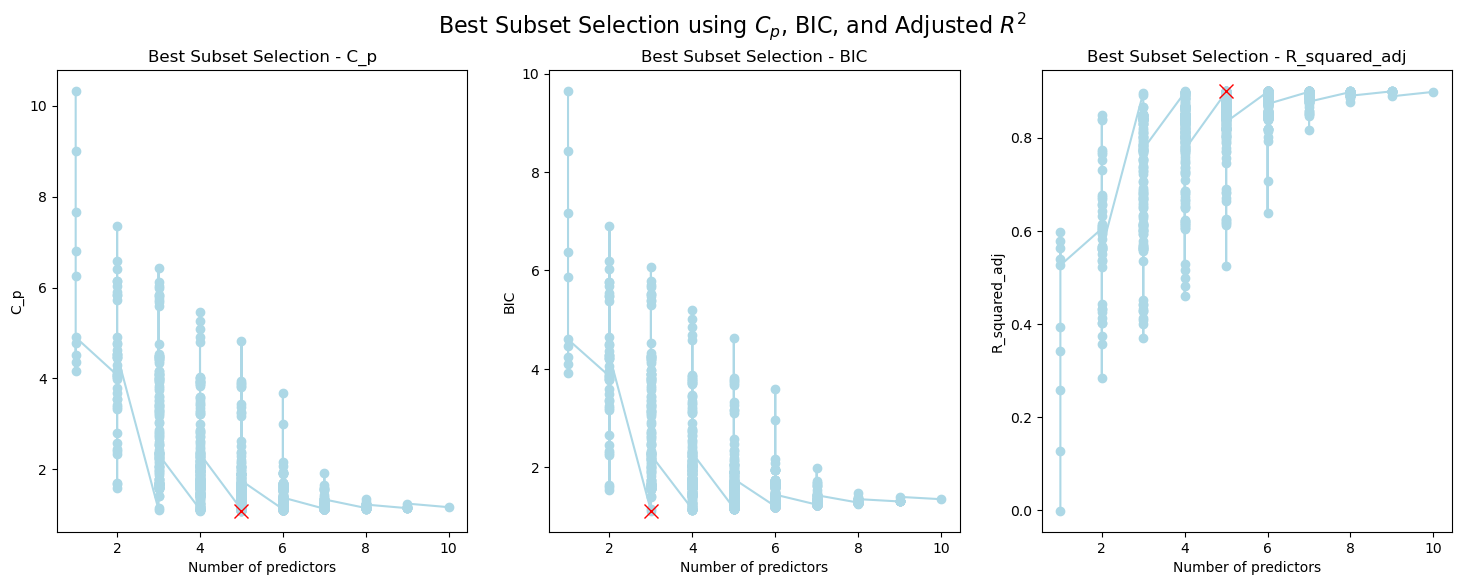

In [132]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


np.random.seed(0)
n = 100
X = np.random.normal(size=n)
epsilon = np.random.normal(size=n)
beta_0, beta_1, beta_2, beta_3 = 1, 2, 2,-1
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + epsilon

X_poly = np.column_stack([X**i for i in range(1, 11)])
X_poly = sm.add_constant(X_poly)

def fit_linear_reg(X, Y):
    model = LinearRegression()
    model.fit(X, Y)
    predictions = model.predict(X)
    RSS = np.sum((Y - predictions)**2)
    R_squared = model.score(X, Y)
    return RSS, R_squared

# Initialize lists to store results
RSS_list, R_squared_list, features_list = [], [], []
numb_features = []


for k in range(1, X_poly.shape[1] + 1):
    for subset in itertools.combinations(range(1, X_poly.shape[1]), k):
        X_subset = X_poly[:, subset]
        RSS, R_squared = fit_linear_reg(X_subset, Y)
        RSS_list.append(RSS)
        R_squared_list.append(R_squared)
        features_list.append(subset)
        numb_features.append(len(subset))

# Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features, 'RSS': RSS_list, 'R_squared': R_squared_list, 'features': features_list})

# Compute additional selection criteria
m = len(Y)
sigma_squared_hat = min(df['RSS']) / (m - max(numb_features) - 1)
df['C_p'] = (1/m) * (df['RSS'] + 2 * df['numb_features'] * sigma_squared_hat)
df['BIC'] = (1/(m * sigma_squared_hat)) * (df['RSS'] + np.log(m) * df['numb_features'] * sigma_squared_hat)
df['R_squared_adj'] = 1 - ((1 - df['R_squared']) * (m - 1) / (m - df['numb_features'] - 1))
ria
variables = ['C_p', 'BIC', 'R_squared_adj']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, var in enumerate(variables):
    axes[i].plot(df['numb_features'], df[var], color='lightblue', marker='o')
    if var == 'R_squared_adj':
        best_index = df[var].idxmax()
    else:
        best_index = df[var].idxmin()
    axes[i].plot(df.loc[best_index, 'numb_features'], df.loc[best_index, var], 'rx', markersize=10)
    axes[i].set_xlabel('Number of predictors')
    axes[i].set_ylabel(var)
    axes[i].set_title(f'Best Subset Selection - {var}')

plt.suptitle('Best Subset Selection using $C_p$, BIC, and Adjusted $R^2$', fontsize=16)
plt.show()


Forward Selection Optimal Subset Sizes:
Best Cp subset size: 6
Best BIC subset size: 6
Best Adjusted R^2 subset size: 10

Backward Selection Optimal Subset Sizes:
Best Cp subset size: 10
Best BIC subset size: 9
Best Adjusted R^2 subset size: 10


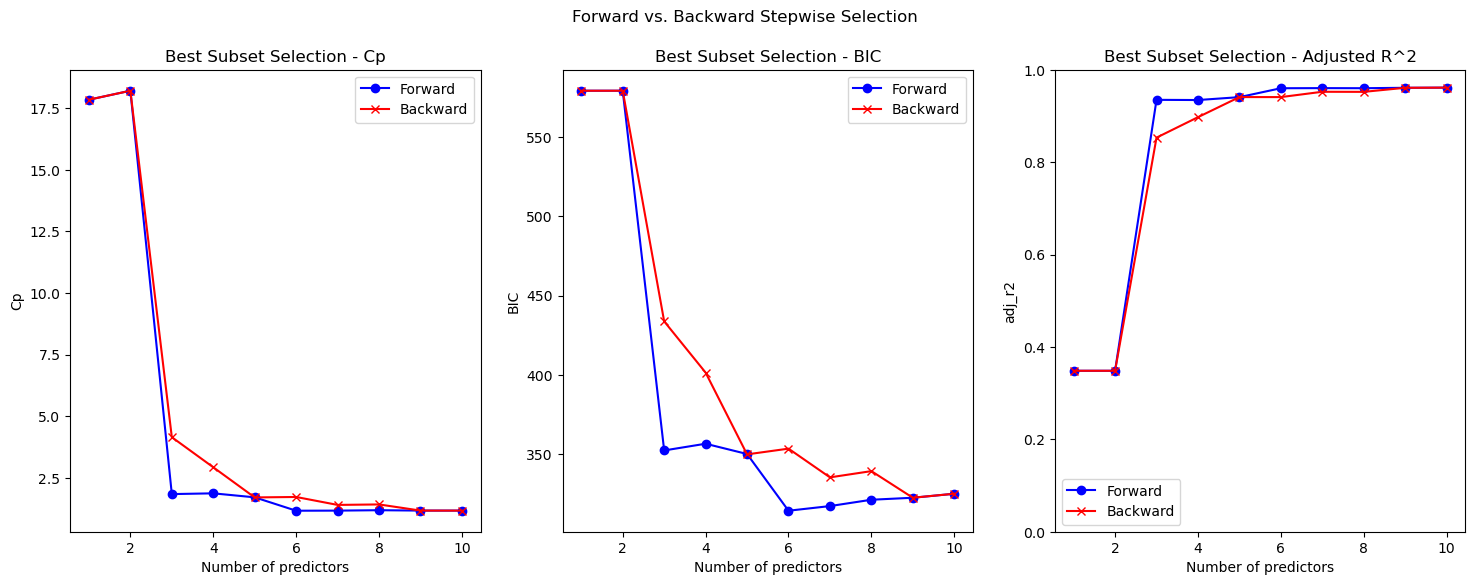

In [133]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Simulate data
np.random.seed(0)
n = 100
X = np.random.normal(size=n)
epsilon = np.random.normal(size=n)
beta_0, beta_1, beta_2, beta_3 = 1, 2, -3, 0.5
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + epsilon

# Create polynomial terms up to X^10
X_poly = np.column_stack([X**i for i in range(1, 11)])
X_poly = sm.add_constant(X_poly)  # Add constant term for intercept

# Define a function to calculate Cp, BIC, and adjusted R^2
def calculate_criteria(X, Y):
    model = sm.OLS(Y, X).fit()
    RSS = np.sum((model.predict(X) - Y) ** 2)
    m = len(Y)
    d = X.shape[1] - 1  # Subtract 1 for the intercept
    sigma_squared_hat = RSS / (m - d - 1)
    Cp = (RSS + 2 * d * sigma_squared_hat) / m
    BIC = model.bic
    adj_r2 = model.rsquared_adj
    return Cp, BIC, adj_r2

# Forward stepwise selection
sfs_forward = SFS(LinearRegression(), k_features="best", forward=True, floating=False, scoring="r2", cv=0)
sfs_forward = sfs_forward.fit(X_poly[:, 1:], Y)  # Exclude the intercept for the selector

# Backward stepwise selection
sfs_backward = SFS(LinearRegression(), k_features="best", forward=False, floating=False, scoring="r2", cv=0)
sfs_backward = sfs_backward.fit(X_poly[:, 1:], Y)  # Exclude the intercept for the selector

# Collect results
results_forward = []
results_backward = []

for subset_size, selected_features in sfs_forward.subsets_.items():
    X_selected = sm.add_constant(X_poly[:, [0] + [i for i in selected_features['feature_idx']]])
    Cp, BIC, adj_r2 = calculate_criteria(X_selected, Y)
    results_forward.append((subset_size, Cp, BIC, adj_r2))

for subset_size, selected_features in sfs_backward.subsets_.items():
    X_selected = sm.add_constant(X_poly[:, [0] + [i for i in selected_features['feature_idx']]])
    Cp, BIC, adj_r2 = calculate_criteria(X_selected, Y)
    results_backward.append((subset_size, Cp, BIC, adj_r2))

# Convert results to DataFrame for comparison
df_forward = pd.DataFrame(results_forward, columns=["subset_size", "Cp", "BIC", "adj_r2"])
df_backward = pd.DataFrame(results_backward, columns=["subset_size", "Cp", "BIC", "adj_r2"])

# Find optimal subset sizes according to each criterion for forward selection
best_cp_forward = df_forward["subset_size"].iloc[df_forward["Cp"].idxmin()]
best_bic_forward = df_forward["subset_size"].iloc[df_forward["BIC"].idxmin()]
best_adj_r2_forward = df_forward["subset_size"].iloc[df_forward["adj_r2"].idxmax()]

# Find optimal subset sizes according to each criterion for backward selection
best_cp_backward = df_backward["subset_size"].iloc[df_backward["Cp"].idxmin()]
best_bic_backward = df_backward["subset_size"].iloc[df_backward["BIC"].idxmin()]
best_adj_r2_backward = df_backward["subset_size"].iloc[df_backward["adj_r2"].idxmax()]

# Display results
print("Forward Selection Optimal Subset Sizes:")
print(f"Best Cp subset size: {best_cp_forward}")
print(f"Best BIC subset size: {best_bic_forward}")
print(f"Best Adjusted R^2 subset size: {best_adj_r2_forward}")

print("\nBackward Selection Optimal Subset Sizes:")
print(f"Best Cp subset size: {best_cp_backward}")
print(f"Best BIC subset size: {best_bic_backward}")
print(f"Best Adjusted R^2 subset size: {best_adj_r2_backward}")

# Plot results for forward and backward selection
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
criteria = ["Cp", "BIC", "adj_r2"]
titles = ["Best Subset Selection - Cp", "Best Subset Selection - BIC", "Best Subset Selection - Adjusted R^2"]

for i, (criterion, title) in enumerate(zip(criteria, titles)):
    axes[i].plot(df_forward["subset_size"], df_forward[criterion], label="Forward", marker="o", color="blue")
    axes[i].plot(df_backward["subset_size"], df_backward[criterion], label="Backward", marker="x", color="red")
    if criterion == "adj_r2":
        axes[i].set_ylim([0, 1])
    axes[i].set_xlabel("Number of predictors")
    axes[i].set_ylabel(criterion)
    axes[i].set_title(title)
    axes[i].legend()

plt.suptitle("Forward vs. Backward Stepwise Selection")
plt.show()


In [123]:
X = mondata3.drop(columns='y')
y = mondata3['y']
#on va utiliser les formules donné dand ISLP website
#Cp= RSS/sigma^2 -n +2*p (avec p le nombre de prédicteurs)
#BIC : on a directement une fonction en Python
#R_adj pareil
tout = []

def cp_calcul(model, y, n):
    rss = ((y-model.predict())**2).sum()
    p = model.df_model+1
    sigma2 = rss/(n-p) 
    return rss/sigma2 -n + 2*p

def bic_calcul(model):
    return model.bic


def r_carre_ajuste(model):
    return model.rsquared_adj


n = len(y) 
for k in range(1, len(X.columns) + 1):
    for combo in combinations(X.columns, k):
        X_subset = sm.add_constant(X[list(combo)]) 
        model = sm.OLS(y, X_subset).fit()
        Cp = cp_calcul(model, y, n)
        BIC = bic_calcul(model)
        adj_r2 = r_carre_ajuste(model)
        tout.append((combo, Cp, BIC, adj_r2, model))

#on va convertir en dataframe pour pouvoir analyser plus facilement 
tout_df = pd.DataFrame(tout, columns=['Predictors', 'Cp', 'BIC', 'Adjusted R^2', 'Model'])
meilleur_cp= tout_df.loc[tout_df['Cp'].idxmin()]
meilleur_bicl = tout_df.loc[tout_df['BIC'].idxmin()]
meilleur_r_carre_adj = tout_df.loc[tout_df['Adjusted R^2'].idxmax()]
print("Meilleur modèles pour: ")
print("Cp:", meilleur_cp['Predictors'])
print(" BIC:", meilleur_bicl['Predictors'])
print("R^2 ajusté:", meilleur_r_carre_adj['Predictors'])
print('Coefficient pour')
print("\n Cp:\n", meilleur_cp['Model'].params)
print("\nBIC:\n", meilleur_bicl['Model'].params)
print("\nR^2 ajusté:\n", meilleur_r_carre_adj['Model'].params)

results_df = pd.DataFrame(tout, columns=['Num Predictors', 'Cp', 'BIC', 'Adjusted R^2'])
results_df = results_df.sort_values(by='Num Predictors')

# Affichage des plots
plt.figure(figsize=(18, 5))

# Plot Cp
plt.subplot(1, 3, 1)
plt.scatter(results_df['Num Predictors'], results_df['Cp'], marker='o')
plt.title('$C_p$ Criterion')
plt.xlabel('Number of Predictors')
plt.ylabel('$C_p$')

# Plot BIC
plt.subplot(1, 3, 2)
plt.scatter(results_df['Num Predictors'], results_df['BIC'], marker='o')
plt.title('BIC')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')

# Plot Adjusted R^2
plt.subplot(1, 3, 3)
plt.scatter(results_df['Num Predictors'], results_df['Adjusted R^2'], marker='o')
plt.title('Adjusted $R^2$')
plt.xlabel('Number of Predictors')
plt.ylabel('Adjusted $R^2$')

plt.tight_layout()
plt.show()


Meilleur modèles pour: 
Cp: ('x',)
 BIC: ('x', 'x^2', 'x^3')
R^2 ajusté: ('x', 'x^2', 'x^3', 'x^9')
Coefficient pour

 Cp:
 const     2.872595
x        11.481718
dtype: float64

BIC:
 const    1.112311
x        2.219467
x^2      1.977508
x^3      2.958981
dtype: float64

R^2 ajusté:
 const    1.083230
x        2.450153
x^2      2.028950
x^3      2.816869
x^9      0.000456
dtype: float64


ValueError: 4 columns passed, passed data had 5 columns

Best model based on Cp: ('x',)
Best model based on BIC: ('x', 'x^2', 'x^3')
Best model based on Adjusted R^2: ('x', 'x^2', 'x^3', 'x^9')

Coefficients of the best model based on Cp:
 const     2.872595
x        11.481718
dtype: float64

Coefficients of the best model based on BIC:
 const    1.112311
x        2.219467
x^2      1.977508
x^3      2.958981
dtype: float64

Coefficients of the best model based on Adjusted R^2:
 const    1.083230
x        2.450153
x^2      2.028950
x^3      2.816869
x^9      0.000456
dtype: float64


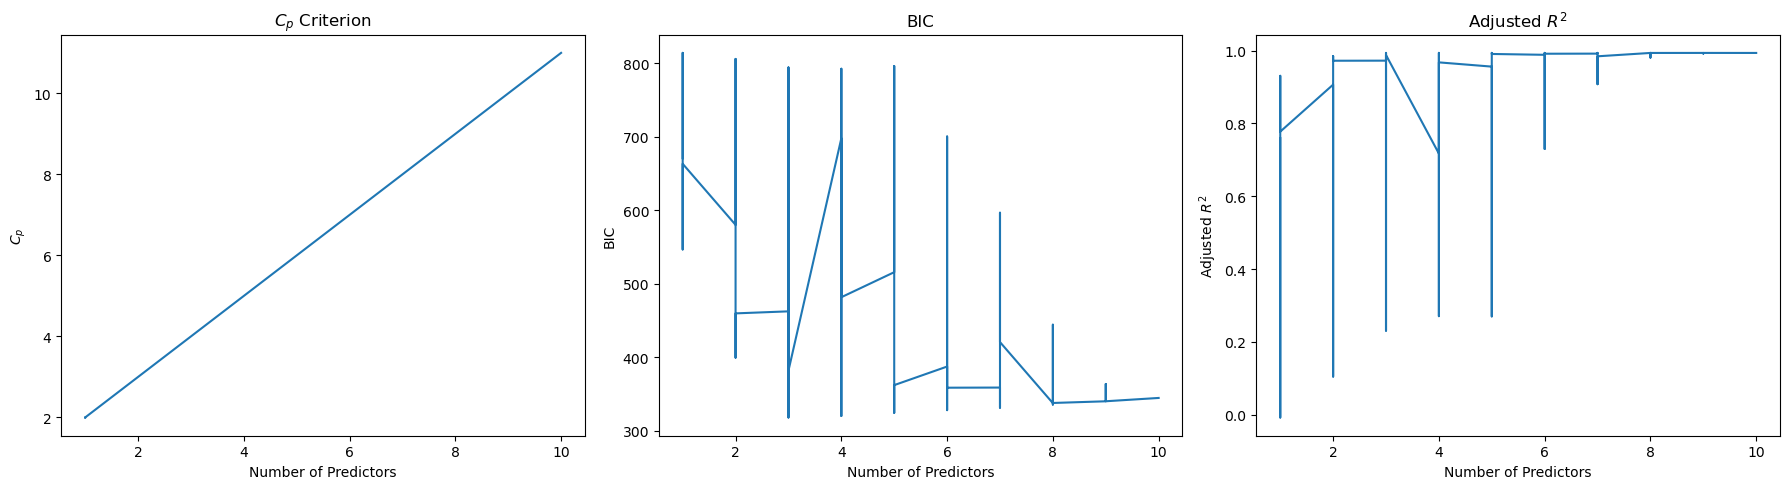

In [120]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import matplotlib.pyplot as plt

# Generate data with polynomial terms up to X^10
matricule = 2405979  
np.random.seed(matricule)
mu, sigma, sigma_epsilon = 0, 1, 1
x = np.random.normal(loc=mu, scale=sigma, size=100)  
e = np.random.normal(loc=0, scale=sigma_epsilon, size=100)  

# Define coefficients and compute y
beta_0, beta_1, beta_2, beta_3 = 1, 2, 2, 3
y = beta_0 + beta_1*x + beta_2*x**2 + beta_3*x**3 + e

# Create DataFrame and add polynomial terms up to X^10
mondata3 = pd.DataFrame({'x': x, 'y': y})
for i in range(2, 11):
    mondata3[f'x^{i}'] = x ** i

# Define predictors and response
X = mondata3.drop(columns='y')
y = mondata3['y']
results = []

# Function to calculate Cp
def calculate_cp(model, y, n):
    rss = ((y - model.predict()) ** 2).sum()
    p = model.df_model + 1  # Number of predictors, including the intercept
    sigma2 = rss / (n - p)
    Cp = rss / sigma2 - n + 2 * p
    return Cp

# Function to calculate BIC
def calculate_bic(model):
    return model.bic

# Function to calculate Adjusted R^2
def calculate_adj_r2(model):
    return model.rsquared_adj

# Loop over all combinations of predictors
n = len(y)  # Number of observations
for k in range(1, len(X.columns) + 1):
    for combo in combinations(X.columns, k):
        X_subset = sm.add_constant(X[list(combo)])  # Add constant term for intercept
        model = sm.OLS(y, X_subset).fit()
        
        # Calculate each metric
        Cp = calculate_cp(model, y, n)
        BIC = calculate_bic(model)
        adj_r2 = calculate_adj_r2(model)
        
        results.append((combo, Cp, BIC, adj_r2, model))

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Predictors', 'Cp', 'BIC', 'Adjusted R^2', 'Model'])

# Identify best models based on each criterion
best_cp_model = results_df.loc[results_df['Cp'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]
best_adj_r2_model = results_df.loc[results_df['Adjusted R^2'].idxmax()]

# Display the best models
print("Best model based on Cp:", best_cp_model['Predictors'])
print("Best model based on BIC:", best_bic_model['Predictors'])
print("Best model based on Adjusted R^2:", best_adj_r2_model['Predictors'])

# Display the coefficients of the best models
print("\nCoefficients of the best model based on Cp:\n", best_cp_model['Model'].params)
print("\nCoefficients of the best model based on BIC:\n", best_bic_model['Model'].params)
print("\nCoefficients of the best model based on Adjusted R^2:\n", best_adj_r2_model['Model'].params)

# Plot Cp, BIC, and Adjusted R^2 against the number of predictors
results_df['Num Predictors'] = results_df['Predictors'].apply(len)
results_df = results_df.sort_values(by='Num Predictors')

plt.figure(figsize=(18, 5))

# Plot Cp
plt.subplot(1, 3, 1)
plt.plot(results_df['Num Predictors'], results_df['Cp'])
plt.title('$C_p$ Criterion')
plt.xlabel('Number of Predictors')
plt.ylabel('$C_p$')

# Plot BIC
plt.subplot(1, 3, 2)
plt.plot(results_df['Num Predictors'], results_df['BIC'])
plt.title('BIC')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')

# Plot Adjusted R^2
plt.subplot(1, 3, 3)
plt.plot(results_df['Num Predictors'], results_df['Adjusted R^2'])
plt.title('Adjusted $R^2$')
plt.xlabel('Number of Predictors')
plt.ylabel('Adjusted $R^2$')

plt.tight_layout()
plt.show()


2. générer les erreurs εi selon une normale N(0, σ^2_ε) avec un σ_ε de votre choix

In [97]:
import numpy as np

# Paramètre pour la distribution normale des erreurs
sigma_epsilon = 1.5  # écart-type des erreurs

# Fixer la graine pour la reproductibilité (utilisez votre matricule)
np.random.seed(2405979)

# Générer 100 erreurs suivant N(0, sigma_epsilon^2)
e = np.random.normal(loc=0, scale=sigma_epsilon, size=100)

# Afficher les premières erreurs
print("Erreurs générées :")
print(e[:10])  # Affiche les 10 premières erreurs


Erreurs générées :
[-0.851576   -1.62915389 -2.12114426 -0.82230077 -0.28039857  3.4543969
  0.52611287  0.38017403 -0.07712454 -1.11201324]
